<h1>Simulation of Multidimensional Feedback System
 at U of Winnipeg¶
</h1>

[Shomi Ahmed]('https://www.linkedin.com/in/shomi74/')

## 1. Introduction
We developed a variety of simulation tools in order to understand the
behavior of the multidimensional PI control loop:

1. **Three-dimensional finite-element analysis simulations in OPERA.**  These were used to simulate
    - the quasi-static magnetic response of the magnetic shield to Earth's field
    - the magnetic response of the magnetic shield to changes in coil-cube currents (in turn enabling us to determine $M$), and
    - the magnetic response of the magnetic shield to the perturbation coil (in turn allowing us to simulate the PI system response to this perturbation.

2. **Field Map Processing in Python.**  The OPERA simulations provided full three-dimensional field maps.  Python scripts were written to process and simplify the information into for example the matrix $M$, or the changes seen at each fluxgate position when the perturbation coil was energized.

3. **PI Simulation in Python.**  With this reduced information in hand, the full PI loop was also simulated in Python in real time.  This allowed us to simulate the full time-dependent response of the feedback and control system to the perturbation coil.

As will be shown, these simulations were quite successful in
describing the system including: the matrix $M$ and its
inverse, and the time-dependent response of the PI loop to
perturbation.

## 2. Simulation in OPERA

![alt text](shield2.png "Title")


The figure shows the geometry as defined in OPERA, both with the magnetic shields. The dimensions of the coils were implemented as wires of square profile 1.24 m $*$ 1.24 m. The perturbation coil is 1.68 m away from the origin, which is at the center of the coil cube. All the information has been written in the *comi* format file which is the command language in OPERA. The files can be found [here]('https://drive.google.com/open?id=1FIOlyrSqQpyQCCokWWxJCmA4_OuheVo6'). The dots in the figure represent some fluxgate positions.  But in general both simulations outputted full field maps so that the fluxgate positions could be adjusted arbitrarily after the simulation was complete.

## 3. Field Map Data

The OPERA simulation gives us total eight data files. They are the followings:
1. 'C1-Vol_1A.csv'
2. 'C2-Vol_1A.csv'
3. 'C3-Vol_1A.csv'
4. 'C4-Vol_1A.csv'
5. 'C5-Vol_1A.csv'
6. 'C6-Vol_1A.csv'
7. 'CoilPerturb-Vol62_0mA.csv'
8. 'CoilPerturb-Vol62_10mA.csv'


The first 6 *csv* files are 6 field maps, one for each of the 6 coils. Each of the file contains  6 columns, where the first 3 columns indicate the $x$,$y$,$z$ coordinates and the last 3 columns indicate the $B_x$,$B_y$,$B_z$ magnetic field  at that point. 

The last 2 *csv* files also another two field maps: one with no current in any coils and another with current only in the perturbation coil.  So, the field map with no current in any coil will generate the setpoint i.e. $B_s(\text{setpoint})$ and the field map with current in perturbation coil will generate the actual measurement i.e. $B_s(\text{measure})$. The difference between $B_s(\text{measure})$ and $B_s(\text{setpoint})$ will generate the change in field $\Delta B$.

## 4. Field Map Processing in Python

In [1]:
# !/usr/bin/env python
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
%matplotlib inline
from datetime import datetime
import time

In [2]:
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'legend.fontsize': 18,
          'xtick.labelsize': 18,
          'ytick.labelsize': 18 
           }
matplotlib.rcParams.update(params)

### 4.1 Coil Perturbation Simulation

In [3]:
#Position of all the fulxgates
##config=1
##s1=[-55,-60,-53] p6
##s2=[51,-58,45] p8
##s3=[-54,59,43] p1
##s4=[56,60,-51] p3

#config=2
#s1=[-54,59,53] #p1
##s2=[-55,59,-51] #p2
#s2=[56,60,-51] #p3
##s4=[56,60,51] #p4
##s5=[-51,-58,48] #p5
#s3=[-47,-60,-36] #p6
##s7=[47,-60,-36] #p7
#s4=[51,-58,48] #p8

#config='2v3'
#s1=[-54,-59,-53] #p1
##s2=[-55,59,-51] #p2
#s2=[56,-60,51] #p3
##s4=[56,60,51] #p4
##s5=[-51,-58,48] #p5
#s3=[-47,60,36] #p6
##s7=[47,-60,-36] #p7
#s4=[51,58,-48] #p8

# config=4
# s1=[-54,-55,-46]
# s2=[52,-55,39]
# s3=[-53,60,42]
# s4=[50,60,-53]



#s1=[-54,-59,-53] #p1
##s2=[-55,59,-51] #p2
#s2=[57,-61,54] #p3
##s4=[56,60,51] #p4
#s3=[-47,60,36] #p6
#s4=[51,58,-48] #p8

config='2v4'
s1=[-54,-57,-53] #p1
s2=[56,-57,51] #p3
s3=[-54,60,36] #p6
s4=[54,59,-38] #p8

#config=3
#s1=[-54,-58,-51]
#s2=[54,-58,49]
#s3=[-54,58,42]
#s4=[51,58,-48]

#config=4
#s1=[-54,-55,-46]
#s2=[52,-55,39]
#s3=[-53,60,42]
#s4=[50,60,-53]

In [4]:
perturb=['0mA','10mA']
dataC=['data_0mA','data_10mA']
dataC_nT=['data_nT_0mA','data_nT_10mA']
p1c=['p1_0mA','p1_10mA']
p2c=['p2_0mA','p2_10mA']
p3c=['p3_0mA','p3_10mA']
p4c=['p4_0mA','p4_10mA']

c1_nT_df=['c1_nT_df_0mA','c1_nT_df_10mA']
C1_nT=['C1_nT_0mA','C1_nT_10mA']
dataC_file=['data_file_0mA','data_file_10mA']

for i in range(0,len(perturb)):
#Collecting Data
	dataC[i]=pd.read_csv('CoilPerturb-Vol62_'+str(perturb[i])+'.csv',sep='\s+',skiprows=7,names=['X', 'Y', 'Z','Bx', 'By', 'Bz'], header=0)

	dataC_nT[i]=dataC[i].loc[:,'Bx':'Bz'].mul(1000000000)
	p1c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s1[0]) & (dataC[i]['Y'] == s1[1]) & (dataC[i]['Z'] == s1[2])]
	p2c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s2[0]) & (dataC[i]['Y'] == s2[1]) & (dataC[i]['Z'] == s2[2])]
	p3c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s3[0]) & (dataC[i]['Y'] == s3[1]) & (dataC[i]['Z'] == s3[2])]
	p4c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s4[0]) & (dataC[i]['Y'] == s4[1]) & (dataC[i]['Z'] == s4[2])]

# 	p1c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s1[0]) & (dataC[i]['Y'] == s1[1]) & (dataC[i]['Z'] == s1[2])].mul([1,-1,-1])
# 	p2c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s2[0]) & (dataC[i]['Y'] == s2[1]) & (dataC[i]['Z'] == s2[2])].mul([1,-1,-1])
# 	p3c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s3[0]) & (dataC[i]['Y'] == s3[1]) & (dataC[i]['Z'] == s3[2])].mul([1,-1,-1])
# 	p4c[i]=dataC_nT[i].loc[(dataC[i]['X'] == s4[0]) & (dataC[i]['Y'] == s4[1]) & (dataC[i]['Z'] == s4[2])].mul([1,-1,-1])

	#each row reprents value of different sensors (in x, y & z axis)  due to coil 1 ignoring the index positions.
	c1_nT_df[i]=pd.concat([p1c[i],p2c[i],p3c[i],p4c[i]], ignore_index=True, axis=0)
	#C1_nT_df.values.flatten()=get rid of everything except values                     
	C1_nT[i]=list(c1_nT_df[i].values.flatten())


	dataC_file[i]=open('sim_Shield_coilPerturb_'+str(perturb[i])+'_p-1,3,6,8_config_'+str(config)+'.csv', 'w')
	
	dataC_file[i].write("{} {} {} {} {} {} {} {} {} {} {} {}".format(C1_nT[i][0], C1_nT[i][1], C1_nT[i][2],C1_nT[i][3],C1_nT[i][4], C1_nT[i][5],C1_nT[i][6], C1_nT[i][7], C1_nT[i][8],C1_nT[i][9],C1_nT[i][10], C1_nT[i][11]))
	
	dataC_file[i].close()
a=np.genfromtxt('sim_Shield_coilPerturb_0mA_p-1,3,6,8_config_'+str(config)+'.csv', delimiter=" ")
b=np.genfromtxt('sim_Shield_coilPerturb_10mA_p-1,3,6,8_config_'+str(config)+'.csv', delimiter=" ")

print('The field change in sensor positions due to 10 mA current in the perturbation coil are ')
print([round(x,2) for x in b-a])

The field change in sensor positions due to 10 mA current in the perturbation coil are 
[24.73, 26.21, -45.3, -11.48, 11.67, -13.04, 12.28, -13.64, -12.45, -17.57, -19.26, -32.33]


### 4.2 Matrix Generation Simulation

In [5]:
name=['C1-Vol_1A','C2-Vol_1A','C3-Vol_1A','C4-Vol_1A','C5-Vol_1A','C6-Vol_1A']
data=['data_C1','data_C2','data_C3','data_C4','data_C5','data_C6']
data_nT=['data_nT_C1','data_nT_C2','data_nT_C3','data_nT_C4','data_nT_C5','data_nT_C6']
p1=['p1_C1_nT','p1_C2_nT','p1_C3_nT','p1_C4_nT','p1_C5_nT','p1_C6_nT']
p2=['p2_C1_nT','p2_C2_nT','p2_C3_nT','p2_C4_nT','p2_C5_nT','p2_C6_nT']
p3=['p3_C1_nT','p3_C2_nT','p3_C3_nT','p3_C4_nT','p3_C5_nT','p3_C6_nT']
p4=['p4_C1_nT','p4_C2_nT','p4_C3_nT','p4_C4_nT','p4_C5_nT','p4_C6_nT']
p5=['p5_C1_nT','p5_C2_nT','p5_C3_nT','p5_C4_nT','p5_C5_nT','p5_C6_nT']
p6=['p6_C1_nT','p6_C2_nT','p6_C3_nT','p6_C4_nT','p6_C5_nT','p6_C6_nT']

mat=[]
c_nT_df=['C1_nT_df','C2_nT_df','C3_nT_df','C4_nT_df','C5_nT_df','C6_nT_df']
c_nT=['C1_nT','C2_nT','C3_nT','C4_nT','C5_nT','C6_nT']

for i in range(0,len(name)):
	#Collecting Data
    data[i]=pd.read_csv(str(name[i])+'.csv',sep='\s+',skiprows=7,names=['X', 'Y', 'Z','Bx', 'By', 'Bz'], header=0)
	#Convert_to_nT
    data_nT[i]=data[i].loc[:,'Bx':'Bz'].mul(1000000000)
	#p=position of the fluxgates, c=coil
    p1[i]=data_nT[i].loc[(data[i]['X'] == s1[0]) & (data[i]['Y'] == s1[1]) & (data[i]['Z'] == s1[2])]
    p2[i]=data_nT[i].loc[(data[i]['X'] == s2[0]) & (data[i]['Y'] == s2[1]) & (data[i]['Z'] == s2[2])]
    p3[i]=data_nT[i].loc[(data[i]['X'] == s3[0]) & (data[i]['Y'] == s3[1]) & (data[i]['Z'] == s3[2])]
    p4[i]=data_nT[i].loc[(data[i]['X'] == s4[0]) & (data[i]['Y'] == s4[1]) & (data[i]['Z'] == s4[2])]

#	p1[i]=data_nT[i].loc[(data[i]['X'] == s1[0]) & (data[i]['Y'] == s1[1]) & (data[i]['Z'] == s1[2])].mul([1,-1,-1])
#	p2[i]=data_nT[i].loc[(data[i]['X'] == s2[0]) & (data[i]['Y'] == s2[1]) & (data[i]['Z'] == s2[2])].mul([1,-1,-1])
#	p3[i]=data_nT[i].loc[(data[i]['X'] == s3[0]) & (data[i]['Y'] == s3[1]) & (data[i]['Z'] == s3[2])].mul([1,-1,-1])
#	p4[i]=data_nT[i].loc[(data[i]['X'] == s4[0]) & (data[i]['Y'] == s4[1]) & (data[i]['Z'] == s4[2])].mul([1,-1,-1])
#	
	#each row reprents value of different sensors (in x, y & z axis)  due to coil 1 ignoring the index positions.
    c_nT_df[i]=pd.concat([p1[i],p2[i],p3[i],p4[i]], ignore_index=True, axis=0)
	#C1_nT_df.values.flatten()=get rid of everything except values                     
    c_nT[i]=list(c_nT_df[i].values.flatten())
    mat.append(c_nT[i])

mat=np.array(mat)
matCond=np.linalg.cond(mat)
##############################################################
data_file=open('sim_Shield_matrix_p1,3,6,8_%d'%(matCond)+'_config_'+str(config)+'.csv', 'w')
for j in range(0,len(mat)):
	channel_data_matrix=("{} {} {} {} {} {} {} {} {} {} {} {}".format(mat[j][0], mat[j][1], mat[j][2],mat[j][3],mat[j][4], mat[j][5],mat[j][6], mat[j][7], mat[j][8],mat[j][9],mat[j][10], mat[j][11]))
	data_file.write(channel_data_matrix +"\n")	
data_file.close()

#### 4.2.1 Matrix Visualization

The matrix is ill conditioned with condition no  30


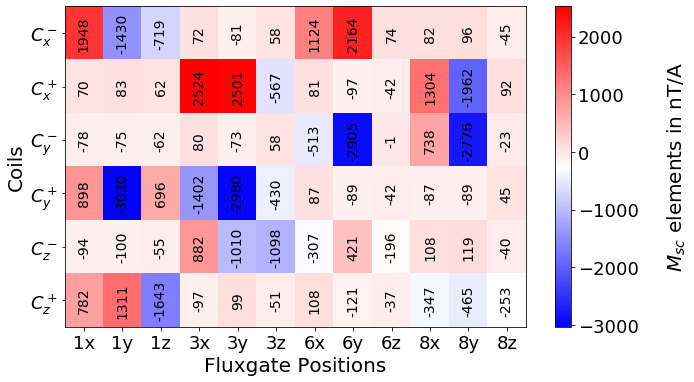

In [6]:
figM, axM = plt.subplots(figsize=(9, 5))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=0.99,
		        wspace=0.0, hspace=0.0)

# cMapM=axM.imshow(mat, interpolation='none', cmap=cm.bwr, aspect='auto')
cMapM = axM.pcolor(mat, cmap=cm.bwr, vmin=max(map(max, mat)), vmax=min(map(min, mat)))
cbarM = figM.colorbar(cMapM)

# put the major ticks at the middle of each cell
axM.set_xticks(np.arange(mat.shape[1])+ 0.5, minor=False)
axM.set_yticks(np.arange(mat.shape[0])+ 0.5, minor=False)

axM.invert_yaxis()

#labels
cbarM.ax.set_ylabel("\n" '$M_{\t{sc}}$ elements in nT/A', rotation=90)
axM.set_xlabel('Fluxgate Positions')
axM.set_ylabel('Coils')

column_labels = ['1x', '1y', '1z','3x', '3y', '3z','6x', '6y', '6z', '8x', '8y', '8z']
row_labels = ['$C_x^-$', '$C_x^+$', '$C_y^-$', '$C_y^+$', '$C_z^-$','$C_z^+$']

axM.set_xticklabels(column_labels, minor=False)
axM.set_yticklabels(row_labels, minor=False)

for r in range (0,len(np.arange(mat.shape[0]))):
	for c in range (0,len(np.arange(mat.shape[1]))):
		axM.text(c+0.5, r+0.5, '%d'%(mat[r][c]), va='center', ha='center', rotation=90, fontsize=14)


figM.savefig('Matrix.png', bbox_inches='tight')
##################################################################
if int(matCond)>4:
    print('The matrix is ill conditioned with condition no ',int(matCond))
else:
    print('The matrix is in good conditioned and you can skip the regularization part')

### 4.2.2 Regularization if ill-conditioned

As seen the matrix is ill-conditoned which can be also interpreted by analysing the diagonal matrix which is as follows
[5867, 4488, 3706, 2570, 1822, 192]
The first diag value is 5867 which is huge compares to the last one 192
The goal is to minimize the diffrences by introducing regularization parameter r
The Diagonal Matrix in log form is :   [3.77, 3.65, 3.57, 3.41, 3.26, 2.28]
r affects most when it is within the above limit
The best r value is 3.00 and condition number is 2.55 


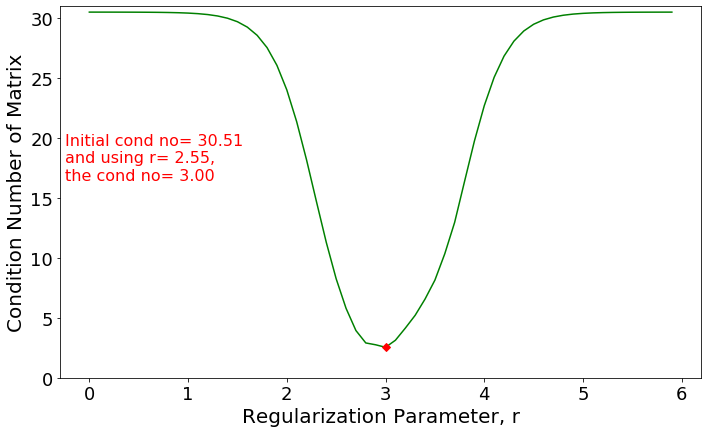

In [7]:
# Defining M and M inverse
M=mat.T #(Here, M=s*c=sensors*coils Matrix  )
U, V, Wt = np.linalg.svd(M, full_matrices=True)
print('As seen the matrix is ill-conditoned which can be also interpreted by analysing the diagonal matrix which is as follows')
print ([int(x) for x in V])
print('The first diag value is {} which is huge compares to the last one {}'.format(int(V[0]),int(V[5])))
print('The goal is to minimize the diffrences by introducing regularization parameter r')
L_V=[]
#for i in range (0,6,1):
for i in range (0,len(np.arange(mat.shape[0])),1):
	L_V.append(round(math.log10(V[i]),2))
    
print ("The Diagonal Matrix in log form is :  ", L_V)
print('r affects most when it is within the above limit')
r=[]
Minv_store=[]
Mcond_store=[]
r2=0
for i in range (0,60):
	r2=i/10.0
	r.append(r2)
	Vmat=np.zeros([len(np.arange(mat.shape[0])),len(np.arange(mat.shape[1]))]) 
	for d in range (0,len(np.arange(mat.shape[0])),1):
		Vmat[d][d]=V[d]/((V[d]**2)+(10**r2)**2)
        
	Minv=np.dot(Wt.T, np.dot(Vmat, U.T))
	Minv_store.append(Minv)
	Mcond=np.linalg.cond(Minv)
	Mcond_store.append(Mcond)
# print ([r[i] for i in range(0,len([i for i, e in enumerate(Mcond_store) if e == np.linalg.cond(M)]))])

best_r=r[Mcond_store.index(min(Mcond_store))]
#print [ '%1.2f' % elem for elem in Mcond_store[479:650]]
print ("The best r value is %1.2f and condition number is %1.2f "  %(best_r,min(Mcond_store)))
####################################Visualization###############
markers_on=Mcond_store.index(min(Mcond_store))
fig=plt.figure(figsize=(10,6))
plt.plot(r, Mcond_store,'g-')
plt.plot(r[markers_on], Mcond_store[markers_on], 'rD')
plt.xlabel('Regularization Parameter, r')
plt.ylabel('Condition Number of Matrix')
plt.ylim([0,math.ceil(max(Mcond_store))])
plt.text(-0.25,(max(Mcond_store)+min(Mcond_store))/2, 
         "Initial cond no= %1.2f \nand using r= %1.2f,\nthe cond no= %1.2f" %(matCond,min(Mcond_store),best_r),
         color='red',fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.11, right=0.99, top=0.97,
                wspace=0.0, hspace=0.0)

#plt.title('Irms vs r for same 30 differnt B-rands with mean '+str(mu)+' & s.d '+str(sigma)+'nT')
# fig.savefig('Mcond_'+str(Minv2)+'.png', bbox_inches='tight')
# plt.show()

## 5. PI Simulation in Python

The matrix $M$ and perturbation coil $\Delta B$ simulations can now be implemented into a dynamic PI simulation.  The $\Delta B$ perturbation can be turned on at a particular time.  Errors in the coil currents are generated using $\Delta B$ and the regularized pseudoinverse of the simulated $M$. The same values of $k_c^p$ and $k_c^i$ are used in the simulation as in the experiment.

We decided to simulate the PI loop in real-time.  In experiment, the time difference between two consecutive feedback loop is found to be 0.146~s. To match the same time of completing a feedback loop both in simulation and experiment, we added a time delay of 0.146 s in the PI simulation code. After adding the time delay, The same process have been repeated for the same time duration as the experiment.

In [8]:
if int(matCond)>4:
    r=best_r #Regularizing ill condtioned matrix
    print('r = {} used to regularize matrix'.format(r))
else:
    r=0
    print('r = {} means matrix is well-conditoned'.format(r))

o=10 #the moment perturbation coil is turned ON in seconds
f=50 #the moment perturbation coil is turned OFF in seconds
z=60 #the total duration of pid simulation for compensation in seconds
kp = 1.0 #proportional value of pid
ki = 0.0 #integration value of pid
#ki = .54/.2
kd = 0.0 #differential value of pid

pos=[1,3,6,8] #position of the sensors as defined in the figure

cdiff=10.0

perturb=0.01*1000 #10 mA perturbation coil current

r = 3.0 used to regularize matrix


In [9]:
# data=np.genfromtxt('sim20k62matrix_p-3,1,6,8_39.csv', delimiter=" ")#(Here, M=c*s=coils*sensors=6*18 Matrix  )
# setpoint=np.genfromtxt('sim20k62CoilPerturb_0mA_p-3,1,6,8.csv', delimiter=" ")
# B_measure=np.genfromtxt('sim20k62CoilPerturb_10mA_p-3,1,6,8.csv', delimiter=" ")
data=np.genfromtxt('sim_Shield_matrix_p1,3,6,8_30_config_2v4.csv', delimiter=" ")#(Here, M=c*s=coils*sensors=6*18 Matrix  )
setpoint=np.genfromtxt('sim_Shield_coilPerturb_0mA_p-1,3,6,8_config_2v4.csv', delimiter=" ")
B_measure=np.genfromtxt('sim_Shield_coilPerturb_10mA_p-1,3,6,8_config_2v4.csv', delimiter=" ")

#####################################################################
M=data.T # M= sensors*coils Matrix

U, V, Wt = np.linalg.svd(M, full_matrices=True)
Vmat=np.zeros([len(np.arange(data.shape[0])),len(np.arange(data.shape[1]))]) 
for d in range (0,len(np.arange(data.shape[0])),1):
	Vmat[d][d]=V[d]/((V[d]**2)+(10**r)**2)
Minv=np.dot(Wt.T, np.dot(Vmat, U.T))
############################################################################
matCnd=np.linalg.cond(M)
print('The matrix condition no is ',round(matCnd,2))

The matrix condition no is  30.51


In [10]:
############################################################################
m=M # nT/A
bext=setpoint
bfield = setpoint
previousCurrent=np.array([0.0]*6)
Setpoint = setpoint

errSum = 0.0
lastErr = 0.0

lastTime = datetime.now()
now = lastTime

timeChange = 0.0
def get_bext():
	global seconds_since_start, bext,Setpoint, B_measure
	if(seconds_since_start < o):
		bext = Setpoint
	elif(seconds_since_start < f):
		bext = B_measure
	else:
		bext = Setpoint

def Compute():
	global lastTime, now, error, errSum, lastErr
	global bfield, current, Setpoint, previousCurrent
	global timeChange
	
	current=previousCurrent
	now = datetime.now()
	timeChange = (now - lastTime).total_seconds()

	time.sleep(0.146)
	errorB = np.array(Setpoint) - np.array(bfield)
	error = np.dot(Minv,errorB)
    
	errSum += error
	dErr = (error - lastErr) / timeChange

	current += kp * error + ki * errSum + kd * dErr

	# Remember some variables for next time
	lastErr = error
	lastTime = now

	previousCurrent=current


whichtime = 0
oldcurrent = 0

def Correct():
	times = 1 # allows to correct on a slower timescale than sample time.
	global bfield, bext, m, current, whichtime, oldcurrent
	whichtime = whichtime + 1
	if (whichtime == times):
		bfield = bext + np.dot(m,current)
		whichtime = 0
		oldcurrent = current
	else:
		bfield = bext + np.dot(m,current)

startTime = now
seconds_since_start = 0.0

T_list = []
Bext_list = []
Bfield_list = []
Current_list = []
Error_list = []
TC_list = []
while(seconds_since_start < z):
	seconds_since_start = (now-startTime).total_seconds()
	print ('Time = {}s'.format(round(seconds_since_start,3)))

	get_bext() # driving the system

	Compute()

	Correct()
    
	current_mA=[j * 1000 for j in current]
	T_list.append(seconds_since_start)
	Bext_list.append(bext)
	Bfield_list.append(bfield)
	Current_list.append(current_mA)
	Error_list.append(error)
	TC_list.append(timeChange)

################################################
##########Saving the B values###################
################################################
data_files = []
data_files.append( open('B-1x_t.csv', 'w') )
data_files.append( open('B-1y_t.csv', 'w') )
data_files.append( open('B-1z_t.csv', 'w') )
data_files.append( open('B-2x_t.csv', 'w') )
data_files.append( open('B-2y_t.csv', 'w') )
data_files.append( open('B-2z_t.csv', 'w') )
data_files.append( open('B-3x_t.csv', 'w') )
data_files.append( open('B-3y_t.csv', 'w') )
data_files.append( open('B-3z_t.csv', 'w') )
data_files.append( open('B-4x_t.csv', 'w') )
data_files.append( open('B-4y_t.csv', 'w') )
data_files.append( open('B-4z_t.csv', 'w') )

#############################################

for l in range(0,len(Bfield_list)):

	for k in range( 0, len( data_files ) ):
		data_files[k].write( "{} {} {}\n".format( Bfield_list[l][k], Bext_list[l][k], T_list[l]) )	

for k in range( 0, len( data_files ) ):
	data_files[k].close()
################################################
##########Saving the current values#############
################################################
current_files=[]
current_files.append( open('C1_t.csv', 'w') )
current_files.append( open('C2_t.csv', 'w') )
current_files.append( open('C3_t.csv', 'w') )
current_files.append( open('C4_t.csv', 'w') )
current_files.append( open('C5_t.csv', 'w') )
current_files.append( open('C6_t.csv', 'w') )

##############################################
for l in range(0,len(Current_list)):

	for k in range( 0, len( current_files ) ):
		current_files[k].write( "{} {}\n".format( Current_list[l][k], T_list[l]) )	

for k in range( 0, len( current_files ) ):
	current_files[k].close()


Time = 0.0s
Time = 0.001s
Time = 0.148s
Time = 0.294s
Time = 0.441s
Time = 0.588s
Time = 0.734s
Time = 0.881s
Time = 1.027s
Time = 1.174s
Time = 1.321s
Time = 1.467s
Time = 1.614s
Time = 1.76s
Time = 1.907s
Time = 2.054s
Time = 2.201s
Time = 2.347s
Time = 2.494s
Time = 2.641s
Time = 2.79s
Time = 2.936s
Time = 3.083s
Time = 3.23s
Time = 3.376s
Time = 3.523s
Time = 3.669s
Time = 3.816s
Time = 3.963s
Time = 4.109s
Time = 4.256s
Time = 4.403s
Time = 4.549s
Time = 4.696s
Time = 4.843s
Time = 4.989s
Time = 5.136s
Time = 5.282s
Time = 5.43s
Time = 5.576s
Time = 5.723s
Time = 5.869s
Time = 6.016s
Time = 6.162s
Time = 6.309s
Time = 6.456s
Time = 6.605s
Time = 6.752s
Time = 6.898s
Time = 7.045s
Time = 7.191s
Time = 7.338s
Time = 7.485s
Time = 7.631s
Time = 7.778s
Time = 7.924s
Time = 8.071s
Time = 8.218s
Time = 8.364s
Time = 8.511s
Time = 8.658s
Time = 8.804s
Time = 8.951s
Time = 9.098s
Time = 9.244s
Time = 9.391s
Time = 9.537s
Time = 9.684s
Time = 9.831s
Time = 9.977s
Time = 10.124s
Time = 10.2

In [11]:
B=[]
dB=[]
Bext=[]
dBext=[]
for i in range(len(Bfield_list[0])):
    B.append([item[i] for item in Bfield_list]) #B field
    dB.append([x- B[i][0] for x in B[i]]) #DeltaB
    Bext.append([item[i] for item in Bext_list]) #Bext field
    dBext.append([x- Bext[i][0] for x in Bext[i]]) #DeltaBext

cCoil=[]
for i in range(len(Current_list[0])):
    cCoil.append([item[i] for item in Current_list])

#####################################################################
combined_dB = np.array(dB)
combined_dBext = np.array(dBext)
combined_C = np.array(cCoil)

#Get the min and max of all your data
minB, maxB = int(np.amin(combined_dB)-1), int(np.amax(combined_dB)+1)
minC, maxC = int(np.amin(combined_C)-1), int(np.amax(combined_C)+1)

print('The minimum and maximum dB are {}nT and {}nT respectively'.format(minB,maxB))
print('The minimum and maximum current are {}mA and {}mA respectively'.format(minC,maxC))

##########################################
sampleTime_store=[]
for i in range(0,len(T_list)-1):
	sampleTime=T_list[i+1]-T_list[i]
	sampleTime_store.append(sampleTime)
sampleTime_avg=np.mean(sampleTime_store)

sampleFreq=round(1/sampleTime_avg)
##########################################
xcoords = [o, f]
colors= ['r','g']
txt= ['ON', 'OFF']

The minimum and maximum dB are -46nT and 52nT respectively
The minimum and maximum current are -75mA and 48mA respectively


Sample Freq = 7.0 Hz


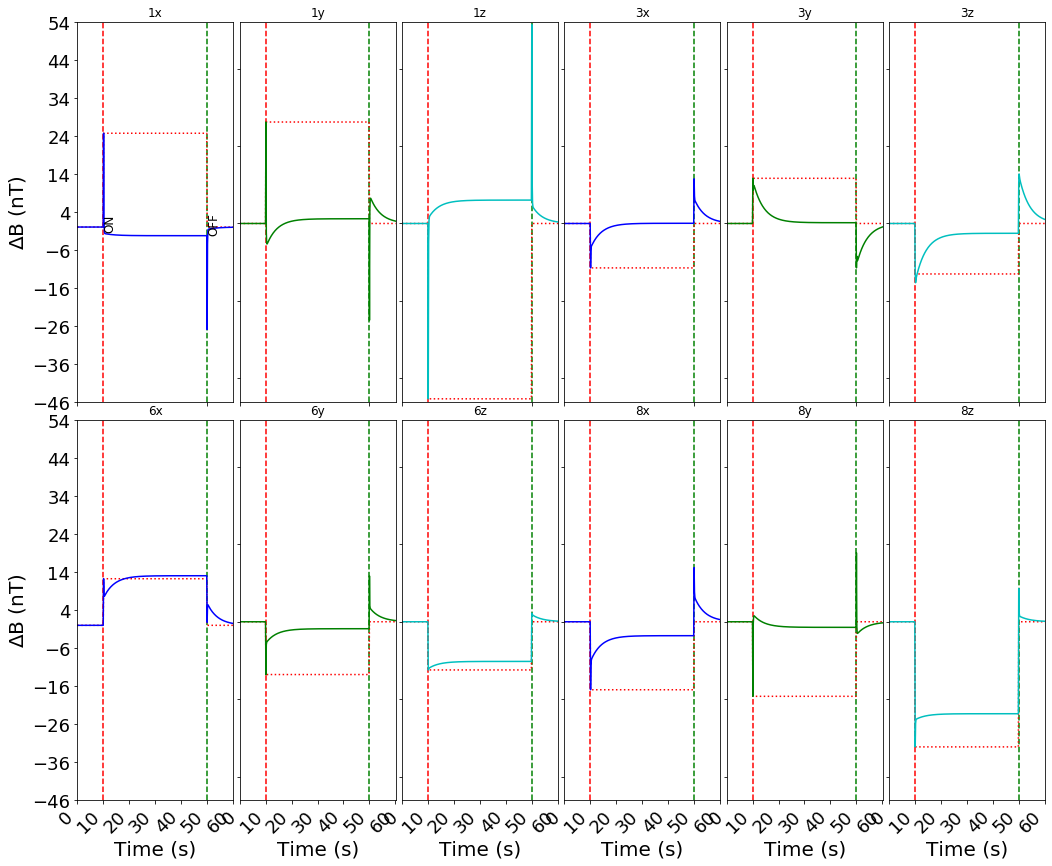

In [12]:
plt.rcParams['figure.figsize'] = [14, 12]

#Creating environment for B vs T for all the sensors
fig1=plt.figure()
plt.subplots_adjust(left=0.03, bottom=0.05, right=0.99, top=0.95,
                wspace=0.04, hspace=0.05)
ax2 = plt.subplot2grid((2, 6), (0, 0))
ax3 = plt.subplot2grid((2, 6), (0, 1))
ax4 = plt.subplot2grid((2, 6), (0, 2))
ax5 = plt.subplot2grid((2, 6), (0, 3))
ax6 = plt.subplot2grid((2, 6), (0, 4))
ax7 = plt.subplot2grid((2, 6), (0, 5))
ax8 = plt.subplot2grid((2, 6), (1, 0))
ax9 = plt.subplot2grid((2, 6), (1, 1))
ax10 = plt.subplot2grid((2, 6), (1, 2))
ax11 = plt.subplot2grid((2, 6), (1, 3))
ax12 = plt.subplot2grid((2, 6), (1, 4))
ax13 = plt.subplot2grid((2, 6), (1, 5))

ax=[ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13]

for i in range(len(ax)):
    plt.setp(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[i].set_ylim([minB, maxB])
    ax[i].margins(0)
######################################################

for i in range(len(xcoords)):
    ax2.text(xcoords[i],1, txt[i],rotation=90, verticalalignment='center',fontsize=12)
    for j in range(len(ax)):
        ax[j].axvline(x=xcoords[i],c=colors[i],ls='--')

x_tick=[ax2,ax3,ax4,ax5,ax6,ax7]
for i in range(len(x_tick)):
    plt.setp(x_tick[i].get_xticklabels(), visible=False)

y_tick=[ax3,ax4,ax5,ax6,ax7,ax9,ax10,ax11,ax12,ax13]

for i in range(len(y_tick)):
    plt.setp(y_tick[i].get_yticklabels(), visible=False)


#ax2.set_yticks(np.arange(minB, maxB, 10))
#ax8.set_yticks(np.arange(minB, maxB, 10))
ax2.set_ylabel(r'$\Delta$B (nT)')
ax8.set_ylabel(r'$\Delta$B (nT)')
# Bext=[Bext_1x,Bext_1y,Bext_1z,Bext_2x,Bext_2y,Bext_2z,
#       Bext_3x,Bext_3y,Bext_3z,Bext_4x,Bext_4y,Bext_4z]
# Bfield=[Bfield_1x,Bfield_1y,Bfield_1z,Bfield_2x,Bfield_2y,Bfield_2z,
#       Bfield_3x,Bfield_3y,Bfield_3z,Bfield_4x,Bfield_4y,Bfield_4z]

##########plotiing Bext######################
for i in range(len(dBext)):
    ax[i].plot(T_list, dBext[i], 'red', ls='dotted')
    
#plotiing Bfield

px=0
for i in range(0,10,3):
    ax[i].plot(T_list, dB[i],'blue')
    ax[i].set_title(''+str(pos[px])+'x')
    px+=1
py=0
for i in range(1,11,3):
    ax[i].plot(T_list, dB[i],'green')
    ax[i].set_title(''+str(pos[py])+'y')
    py+=1
pz=0    
for i in range(2,12,3):
    ax[i].plot(T_list, dB[i],'c')
    ax[i].set_title(''+str(pos[pz])+'z')
    pz+=1

###############labelling##############
for i in [0,int(len(ax)/2)]:
    ax[i].set_ylabel(r'$\Delta$B (nT)')
    ax[i].set_yticks(np.arange(minB, maxB+10, 10))
for i in range(6,12):
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xticks(np.arange(0, z+10, 10))
######################################    
#plt.suptitle('For r='+str(r)+', p='+str(kp)+', i='+str(ki)+', perturb = '+str(perturb)+' mA, sample time = '+str(sampleTime_avg)+' s & sample freq.='+str(sampleFreq)+' Hz. \n Here, NC=No Compensation, Bfield = Solid Line & Bext = Dashed')
#plt.suptitle('For r='+str(r)+', p='+str(kp)+', i='+str(ki)+', perturb = '+str(perturb)+' mA,sample freq.='+str(sampleFreq)+' Hz. Here, Bfield = Solid Line & Bext = Dashed')
print('Sample Freq = {} Hz'.format(sampleFreq))


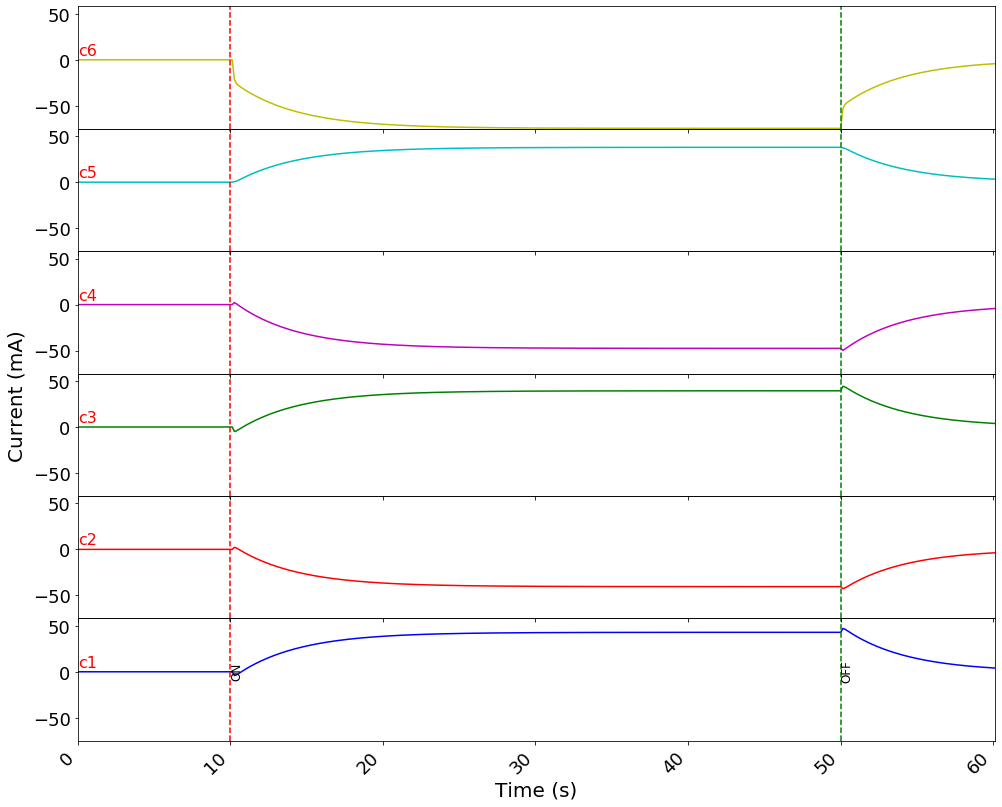

In [13]:
fig2 = plt.figure()
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.99, top=0.95,
                wspace=0.0, hspace=0.0)
ax1_1 = fig2.add_subplot(6, 1, 6)
ax1_2 = fig2.add_subplot(6, 1, 5)
ax1_3 = fig2.add_subplot(6, 1, 4)
ax1_4 = fig2.add_subplot(6, 1, 3)
ax1_5 = fig2.add_subplot(6, 1, 2)
ax1_6 = fig2.add_subplot(6, 1, 1)

axC=[ax1_1,ax1_2,ax1_3,ax1_4,ax1_5,ax1_6]
clr=['b','r','g','m','c','y']
ctxt=['c1','c2','c3','c4','c5','c6']
for i in range(len(axC)):
    axC[i].plot(T_list, cCoil[i],clr[i])
    axC[i].set_ylim([minC, maxC+10])
    axC[i].margins(0)
    axC[i].text(0,10, ctxt[i],rotation=0, verticalalignment='center',fontsize=16, color='r')
    #plt.suptitle('Currents in different coils')
    
#fig1.text(0.5, 0.04, 'Time (s)', ha='center')
ax1_1.set_xlabel('Time (s)')
fig2.text(0.01, 0.5, 'Current (mA)', va='center', rotation='vertical',fontsize=20)
    
for i in range(len(xcoords)):
    ax1_1.text(xcoords[i],1, txt[i],rotation=90, verticalalignment='center',fontsize=12)
    for j in range(len(axC)):
        axC[j].axvline(x=xcoords[i],c=colors[i],ls='--')
        
plt.setp(ax1_1.get_xticklabels(), rotation=45, horizontalalignment='right')
for i in range(1,len(axC)):
    plt.setp(axC[i].get_xticklabels(), visible=False)


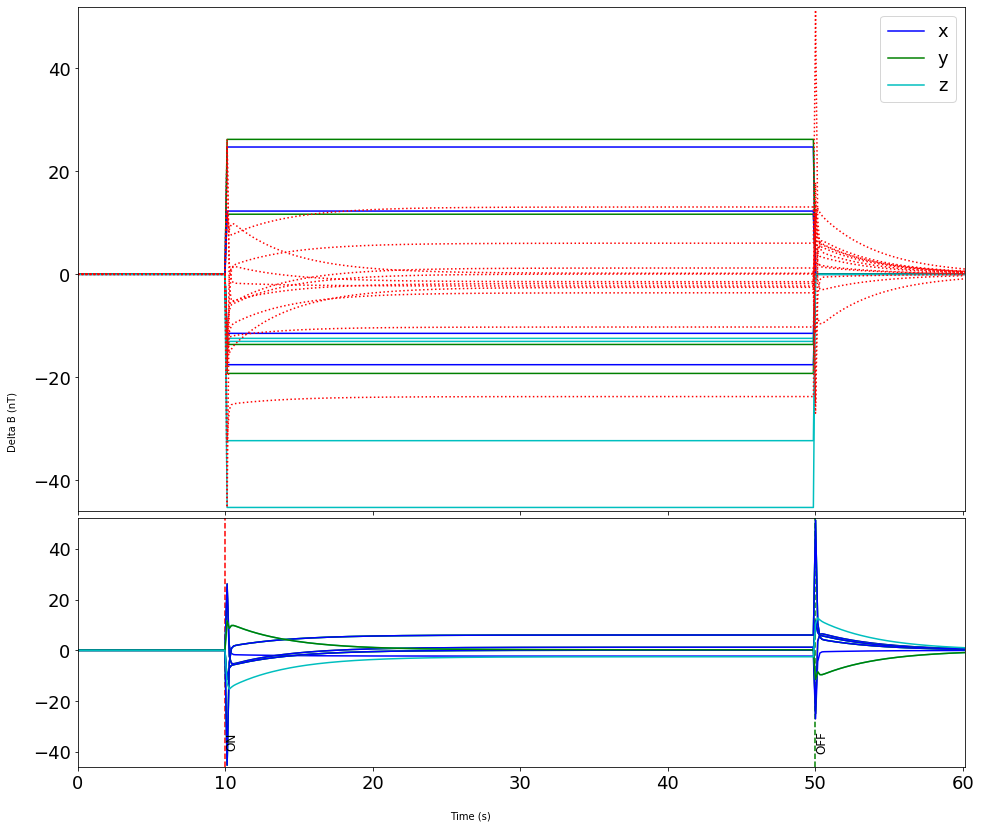

In [14]:
fig3 = plt.figure()

#ax_all=plt.subplot()
ax_all = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax_Bfield = plt.subplot2grid((3, 1), (2, 0))


#plt.setp(ax_all.get_xticklabels(), rotation=45, horizontalalignment='right')

#ax_all.ticklabel_format(useOffset=False, axis='y')
ax_all.set_ylim([minB, maxB])
ax_Bfield.set_ylim([minB, maxB])

plt.setp(ax_all.get_xticklabels(), visible=False)
plt.subplots_adjust(left=0.11, bottom=0.1, right=0.99, top=0.98,
		        wspace=0.0, hspace=0.03)
ax_all.margins(0)
ax_Bfield.margins(0)
#ax_Bfield.set_xticks(np.arange(min(T_list), max(T_list), 10))
fig3.text(0.5, 0.04, 'Time (s)', ha='center')
fig3.text(0.04, 0.5, 'Delta B (nT)', va='center', rotation='vertical')
######################################################

# xcoords = [o, f]
# colors= ['r','g']
# txt= ['ON', 'OFF']
for i in range(0,2):
	ax_Bfield.axvline(x=xcoords[i],c=colors[i],ls='--')
	ax_Bfield.text(xcoords[i],(minB+10), txt[i],rotation=90, verticalalignment='center',fontsize=12)
x,y,z=ax_all.plot(T_list, dBext[0], 'b',T_list, dBext[1], 'g',T_list, dBext[2], 'c')
ax_all.legend((x,y,z),('x','y','z'))
ax_all.plot(T_list, dBext[3], 'b',T_list, dBext[4], 'g',T_list, dBext[5], 'c',
            T_list, dBext[6], 'b',T_list, dBext[7], 'g',T_list, dBext[8], 'c',
            T_list, dBext[9], 'b',T_list, dBext[10], 'g',T_list, dBext[11], 'c')

for i in range(len(dB)):
    ax_all.plot(T_list, dB[i], 'r:')
for i in range(int(len(dB)/3)):
    ax_Bfield.plot(T_list, dB[i], 'b',T_list, dB[i+1], 'g',T_list, dB[i+2], 'c')
#plt.suptitle('For '+str(effResBit[res])+' bits, r='+str(r)+', p='+str(p_pid)+', i='+str(i_pid)+', perturb = '+str(perturb)+' mA, \n sample time = '+str(sampleTime_avg)+' s & sample freq.='+str(sampleFreq)+' Hz.')



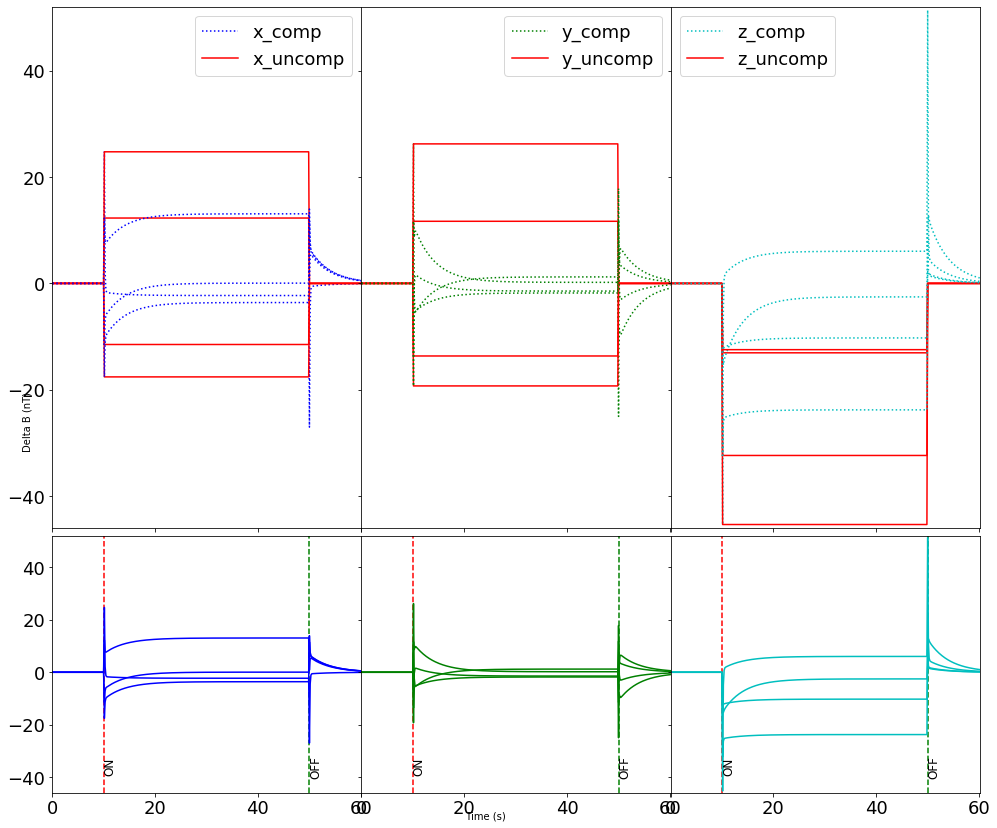

In [15]:
##########################################################################
fig4 = plt.figure()

#ax=plt.subplot()
ax_x_all = plt.subplot2grid((3, 3), (0, 0), rowspan=2)
ax_y_all = plt.subplot2grid((3, 3), (0, 1), rowspan=2)
ax_z_all = plt.subplot2grid((3, 3), (0, 2), rowspan=2)

ax_x_Bfield = plt.subplot2grid((3, 3), (2, 0))
ax_y_Bfield = plt.subplot2grid((3, 3), (2, 1))
ax_z_Bfield = plt.subplot2grid((3, 3), (2, 2))


#plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

#ax.ticklabel_format(useOffset=False, axis='y')
ax_x_all.set_ylim([minB, maxB])
ax_y_all.set_ylim([minB, maxB])
ax_z_all.set_ylim([minB, maxB])

ax_x_Bfield.set_ylim([minB, maxB])
ax_y_Bfield.set_ylim([minB, maxB])
ax_z_Bfield.set_ylim([minB, maxB])

plt.setp(ax_x_all.get_xticklabels(), visible=False)
plt.setp(ax_y_all.get_xticklabels(), visible=False)
plt.setp(ax_z_all.get_xticklabels(), visible=False)
plt.setp(ax_y_all.get_yticklabels(), visible=False)
plt.setp(ax_z_all.get_yticklabels(), visible=False)
plt.setp(ax_y_Bfield.get_yticklabels(), visible=False)
plt.setp(ax_z_Bfield.get_yticklabels(), visible=False)

plt.subplots_adjust(left=0.07, bottom=0.07, right=0.99, top=0.98,
		        wspace=0.0, hspace=0.03)
ax_x_all.margins(0)
ax_y_all.margins(0)
ax_z_all.margins(0)

ax_x_Bfield.margins(0)
ax_y_Bfield.margins(0)
ax_z_Bfield.margins(0)

fig4.text(0.5, 0.04, 'Time (s)', ha='center')
fig4.text(0.04, 0.5, 'Delta B (nT)', va='center', rotation='vertical')
######################################################
######################################################

xcoords = [o, f]
colors= ['r','g']
txt= ['ON', 'OFF']
for i in range(0,2):
	ax_x_Bfield.axvline(x=xcoords[i],c=colors[i],ls='--')
	ax_x_Bfield.text(xcoords[i],(minB+10), txt[i],rotation=90, verticalalignment='center',fontsize=12)
	ax_y_Bfield.axvline(x=xcoords[i],c=colors[i],ls='--')
	ax_y_Bfield.text(xcoords[i],(minB+10), txt[i],rotation=90, verticalalignment='center',fontsize=12)
	ax_z_Bfield.axvline(x=xcoords[i],c=colors[i],ls='--')
	ax_z_Bfield.text(xcoords[i],(minB+10), txt[i],rotation=90, verticalalignment='center',fontsize=12)

x_comp,x_uncomp=ax_x_all.plot(T_list, dB[0], 'b:', T_list, dBext[0], 'r')
ax_x_all.legend((x_comp,x_uncomp),('x_comp','x_uncomp'))

ax_x_Bfield.plot(T_list, dB[0], 'b')
for i in range(3,10,3):
    ax_x_all.plot(T_list, dBext[i], 'r', T_list, dB[i], 'b:')
    ax_x_Bfield.plot(T_list, dB[i], 'b')
    
y_comp,y_uncomp=ax_y_all.plot(T_list, dB[1], 'g:', T_list, dBext[1], 'r')
ax_y_all.legend((y_comp,y_uncomp),('y_comp','y_uncomp'))

ax_y_Bfield.plot(T_list, dB[1], 'g')
for i in range(4,11,3):
    ax_y_all.plot(T_list, dBext[i], 'r', T_list, dB[i], 'g:')
    ax_y_Bfield.plot(T_list, dB[i], 'g')

z_comp,z_uncomp=ax_z_all.plot(T_list, dB[2], 'c:', T_list, dBext[2], 'r')
ax_z_all.legend((z_comp,z_uncomp),('z_comp','z_uncomp'))

ax_z_Bfield.plot(T_list, dB[2], 'c')
for i in range(5,12,3):
    ax_z_all.plot(T_list, dBext[i], 'r', T_list, dB[i], 'c:')
    ax_z_Bfield.plot(T_list, dB[i], 'c')
    

In [16]:
print(len(cCoil))

6


Text(0, 0.5, '$\\Delta$B field (nT)')

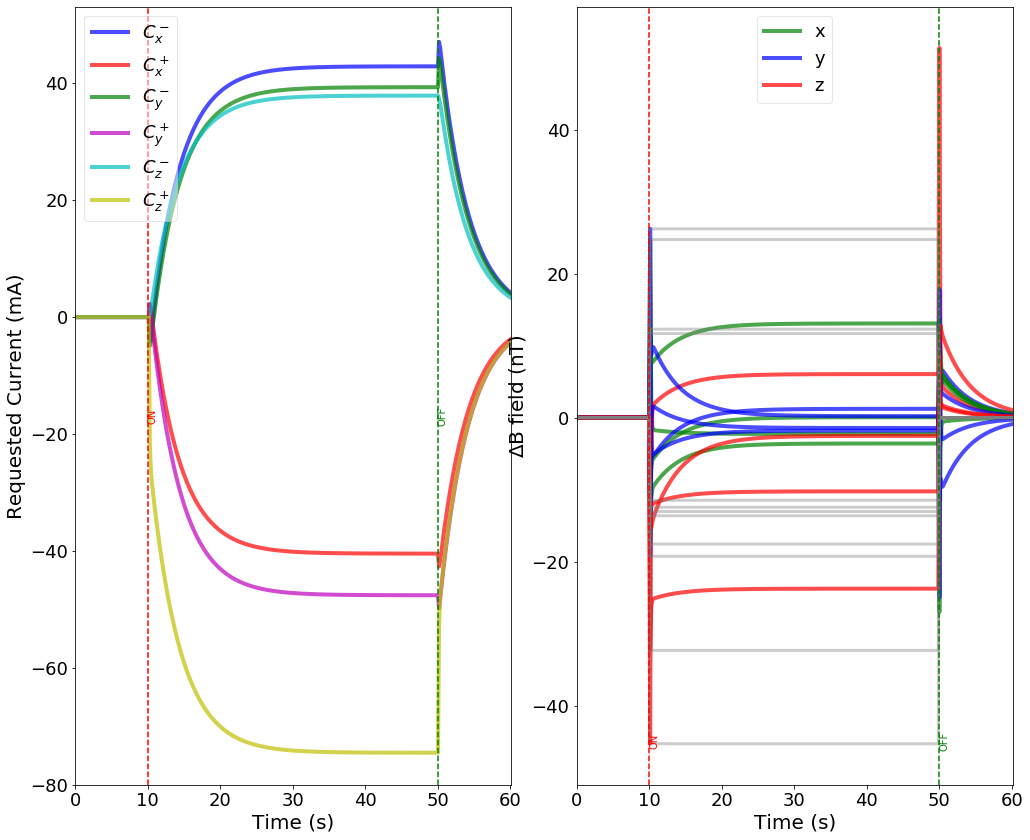

In [17]:
fig5=plt.figure()
ax1_c=plt.subplot(1,2,1)
ax7_b=plt.subplot (1,2,2)
plt.subplots_adjust(left=0.06, bottom=0.08, right=0.99, top=0.98,
		        wspace=0.15, hspace=0.03)

for i in range(len(cCoil)):
    ax1_c.plot(T_list, cCoil[i],clr[i],lw=4,alpha=0.7,label=row_labels[i])
    ax1_c.legend(fancybox=True, framealpha=0.5,loc='upper left')

ax7_b.plot(T_list,dB[0], 'g',alpha=0.7,lw=4,label='x')
ax7_b.legend(fancybox=True, framealpha=0.5,loc=0)
ax7_b.plot(T_list,dB[1], 'b',alpha=0.7,lw=4,label='y')
ax7_b.legend(fancybox=True, framealpha=0.5,loc=0)
ax7_b.plot(T_list,dB[2], 'r',alpha=0.7,lw=4,label='z')
ax7_b.legend(fancybox=True, framealpha=0.5,loc=0)

for i in range(3,10,3):
    ax7_b.plot(T_list,dB[i], 'g',alpha=0.7,lw=4)
    
for i in range(4,11,3):
    ax7_b.plot(T_list,dB[i], 'b',alpha=0.7,lw=4)

for i in range(5,12,3):
    ax7_b.plot(T_list,dB[i], 'r',alpha=0.7,lw=4)

for i in range(len(dBext)):
    ax7_b.plot(T_list, dBext[i],'grey',alpha=0.4,lw=3)


for i in range(0,2):
	ax1_c.axvline(x=xcoords[i],c=colors[i],ls='--')
#	ax1_c.text(xcoords[i],95, txt[i],rotation=90, verticalalignment='center',color=colors[i])
	ax1_c.text(xcoords[i],-17, txt[i],rotation=90, verticalalignment='center',color=colors[i])
	ax7_b.axvline(x=xcoords[i],c=colors[i],ls='--')
	ax7_b.text(xcoords[i],-45, txt[i],rotation=90, verticalalignment='center',color=colors[i])


ax1_c.margins(0)

ax1_c.set_ylim([minC-5, maxC+5])
ax7_b.set_ylim([minB-5, maxB+5])

#ax1_c.yaxis.set_major_locator(plt.MaxNLocator(7))
ax7_b.margins(0)

ax1_c.set_xlabel('Time (s)')
ax1_c.set_ylabel('Requested Current (mA)')

ax7_b.set_xlabel('Time (s)')
ax7_b.set_ylabel('$\Delta$B field (nT)')



In [18]:
###################################
plt.pause(0.1)
fig1.savefig('r'+str(r)+'_p'+str(kp)+'_i'+str(ki)+'_np_sim.png', bbox_inches='tight')
fig2.savefig('c_r'+str(r)+'_p'+str(kp)+'_i'+str(ki)+'_np_sim.png', bbox_inches='tight')
########################################
fig3.savefig('B_t_all-for_r='+str(r)+'-and-pos='+str(pos[0])+','+str(pos[1])+','+str(pos[2])+','+str(pos[3])+'.png', bbox_inches='tight')
fig4.savefig('B_t-for_r='+str(r)+'-and-pos='+str(pos[0])+','+str(pos[1])+','+str(pos[2])+','+str(pos[3])+'.png', bbox_inches='tight')
#fig2.savefig('t_i-for_r='+str(r)+'-and-pos='+str(pos1)+','+str(pos2)+','+str(pos3)+','+str(pos4)+','+str(pos5)+'.png', bbox_inches='tight')

# plt.show()

This notebook contains a particular portion of masters thesis of [Shomi Ahmed]('https://www.linkedin.com/in/shomi74/'). The details of the work can be found on [Active magnetic compensation prototype for a neutron electric dipole moment experiment]('http://hdl.handle.net/1993/33914').